 netconvert --node-files project2.nod.xml --edge-files peoject2.edge.xml -t project2.type.xml -o project2.net.xml 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import traci
import time
import xml.etree.ElementTree as ET
import pandas as pd

generate random vehicle arrival that follows the poisson process

[1.6200839335442236, 1.0887539358621479, 1.8780549457938593, 0.48447143395289755, 0.11999796069413218, 0.7332303220112866, 0.8273244396696506, 1.6079637533190598, 0.1382621175703659, 0.6865390242839776, 0.8489576001789612, 0.30718455658054516, 1.3684741371033644, 1.4211790456886304, 0.7061026204763515, 0.2504016663146266, 2.192286587052567, 0.039395629376656305, 1.1870120988752308, 0.5060921217135094, 0.3055670669064274, 0.47773905645278403, 1.6700346310275935, 1.5943579388523947, 1.919484399319667, 0.5712615627216333, 0.30879891352457817, 0.8226264448732413, 0.4493368007234083, 0.31230608186533193, 2.58601706829473, 0.5346643875139824, 5.410491001232697, 1.415460512178135, 1.3533209699358664, 2.9136966494242356, 0.4432264645704233, 1.027778501039265, 1.334612044560772, 0.7069942516943587, 2.114052006751438, 2.1928349295804117, 1.074097891369313, 0.13763772112412717, 0.6158676418267205, 0.16971399418596275, 1.2241980291582497, 2.4932752961299984, 0.33299394446648267, 0.0824712631865479

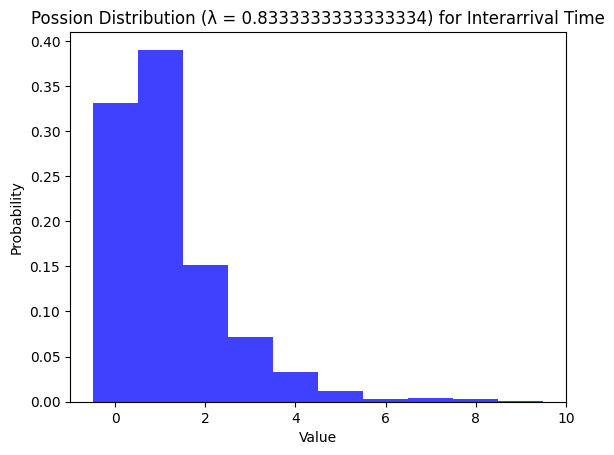

In [2]:
def generate_interarrival_time(lamda):
  start_time=0
  t = start_time

  u1 = np.random.random()
  t -= np.log(u1) / lamda
  
  return t

arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour


# Plot the histogram of multiple generated arrival time random variables
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

print(interarrival_times)

# Plot the histogram of generated arrival time random variables
plt.hist(interarrival_times, bins=np.arange(min(interarrival_times), max(interarrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title(f'Possion Distribution (λ = {arrival_rate}) for Interarrival Time')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called project2.rou.xml.

In [3]:
def vehicle2file(interarrival_times):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open('project2.rou.xml', 'w') as f:
        f.write('<routes>\n')
        f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="40" sigma="0.0" carFollowModel="IDM"/>\n')
        f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="25" sigma="0.0" carFollowModel="IDM" />\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        depart_time=0 
        for num_vehicles,time in enumerate(interarrival_times):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            depart_time+=time

            vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]
            f.write(f'<vehicle depart="{depart_time}" route="r1" id="{num_vehicles}" type="{vehicle_type}"/>\n')
        f.write('</routes>')

In [4]:
# Run the simulation for a certain number of steps
# simulation_steps = 3600  
# warmup_steps = 1000

# Specify the network file based on the scenario you want to run
# network_file = f"project2.net.xml"
# configuration_file=f'project2.sumo.cfg'

# generate the arrival time that follows the poisson process
arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

# generate the new rou.xml
vehicle2file(interarrival_times)

In project2.add.xml, we put the loop detectors at the beginning and the end of the edge 4 for each lane to measure inflow and outflow per lane. And we let the detecotrs collect the data each 5 minutes.

### task1

The first task is to estimate traffic densities of edge 4 per 5 minutes during
simulated one hour period using traffic flow data from detectors at both
boundaries. Hint: virtual loop detectors can be added in SUMO model
to simulate loop detector data; the density can be estimated continuously
using the conservation law i.e. the variation rate of density of a road section
is compensated by the flow change in a road section i.e. ρk(t + ∆t) =
ρk(t) + 1/∆xk(Q0k − Q1k)∆t.

ρk(t) is the traffic density on lane k at time t  
∆xk is the length of lane k  
Q0k is the inflow (traffic entering) at the begining of lane k  
Q1k is the outflow (traffic leaving) at the end of lane k  
∆t is the time step

After running the simulation by using SUMO, we obtain the detector output files. In our code, we first parse these files into dataframe.

In [3]:
# Parse the XML data
def parse_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()   
    # Placeholder for detector data
    detector_data = []
    # Iterate through intervals
    for interval in root.findall('interval'):
        data = {
            'begin': float(interval.get('begin')),
            'end': float(interval.get('end')),
            'id': interval.get('id'),
            'nVehContrib': int(interval.get('nVehContrib')),
            'flow': float(interval.get('flow')),
            'occupancy': float(interval.get('occupancy')),
            'speed': float(interval.get('speed')),
            'harmonicMeanSpeed': float(interval.get('harmonicMeanSpeed')),
            'length': float(interval.get('length')),
            'nVehEntered': int(interval.get('nVehEntered'))
        }
        detector_data.append(data)

    # Convert to pandas DataFrame
    df = pd.DataFrame(detector_data)
    # Print the DataFrame
    print(df)
    return df

In [4]:
begin_xml_paths=['output_begin_edge4_1.xml','output_begin_edge4_2.xml','output_begin_edge4_3.xml']
end_xml_paths=['output_end_edge4_1.xml','output_end_edge4_2.xml','output_end_edge4_3.xml']

detector_begin_df=[]
detector_end_df=[]

for p in begin_xml_paths:
 detector_begin_df.append(parse_xml_file(p)) 

for p in end_xml_paths:
 detector_end_df.append(parse_xml_file(p)) 

     begin     end                     id  nVehContrib   flow  occupancy  \
0      0.0   300.0  begin_detecor_edge4_0           19  228.0       3.18   
1    300.0   600.0  begin_detecor_edge4_0           42  504.0       8.04   
2    600.0   900.0  begin_detecor_edge4_0           40  480.0       5.61   
3    900.0  1200.0  begin_detecor_edge4_0           39  468.0       5.76   
4   1200.0  1500.0  begin_detecor_edge4_0           39  468.0       7.17   
5   1500.0  1800.0  begin_detecor_edge4_0           36  432.0       6.33   
6   1800.0  2100.0  begin_detecor_edge4_0           38  456.0       4.99   
7   2100.0  2400.0  begin_detecor_edge4_0           38  456.0       7.03   
8   2400.0  2700.0  begin_detecor_edge4_0           39  468.0       6.33   
9   2700.0  3000.0  begin_detecor_edge4_0           37  444.0       6.42   
10  3000.0  3300.0  begin_detecor_edge4_0           39  468.0       6.32   
11  3300.0  3600.0  begin_detecor_edge4_0           41  492.0       6.51   

    speed  

Then we estimate the traffic densities of edge 4 using traffic flow data from detectors at both boundaries.

To estimate traffic densities of edge 4 per 5 minutes during a simulated one-hour period using traffic flow data from detectors at both boundaries, we follow these steps: 

1. Calculate Flow Rates: 
Use the flow data from the detectors (flow column in the DataFrames) to calculate the inflow and outflow rates for each lane and each 5-minute interval. The flow rate represents the number of vehicles passing through a point in a given time period.
  
2. Compute Density Changes:  
Apply the conservation law mentioned in the hint to compute the traffic density changes.   

3. Compute Average Densities:  
Calculate the average density for each 5-minute interval. This can be done by summing up the density changes for all lanes and dividing by the total number of lanes.

4. Visualize Results:  
create plots or tables to visualize the estimated traffic densities over time.

In [5]:
# Step 1: Calculate Flow Rates 
inflow_rates = [df['flow'].values for df in detector_begin_df]
outflow_rates = [df['flow'].values for df in detector_end_df]

In [48]:
# Step 2: Compute Density Changes
delta_t = 300.0  # 5 minutes in seconds
delta_x = 1000  #length of lanes

# density_changes is a list of density changes for each time period
density_changes = [(inflow - outflow) / delta_x * delta_t for inflow, outflow in zip(inflow_rates, outflow_rates)]

# density_changes is a list of lists where each inner list represents the density change for a lane for each time period
cumulative_densities = [[0] for _ in range(len(density_changes))]  # Initial density is zero for each lane
for density_change_for_lane in zip(*density_changes):
    for lane_index, density_change in enumerate(density_change_for_lane):
        # Calculate the cumulative density for the next time step for each lane
        next_density = cumulative_densities[lane_index][-1] + density_change
        cumulative_densities[lane_index].append(next_density)

# Now, cumulative_densities contains the cumulative densities for each lane at each time step

In [27]:
# Step 3: Compute Average Densities
average_densities = [sum(cumulative_densities) / len(cumulative_densities) for cumulative_densities in zip(*cumulative_densities)]

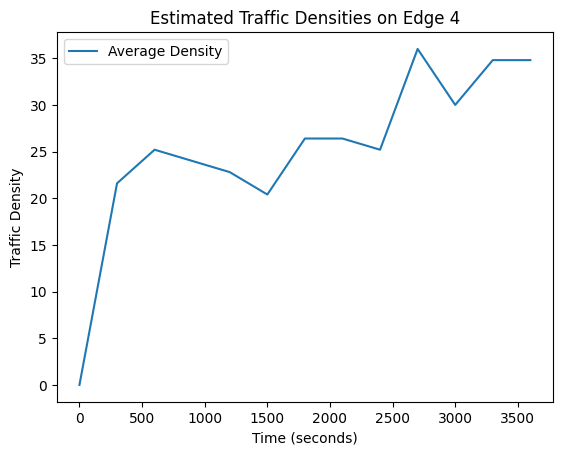

In [47]:
# Step 4: Visualize Results
time_intervals = np.append(detector_begin_df[0]['begin'].values,3600.00)
plt.plot(time_intervals, average_densities, label='Average Density')
plt.xlabel('Time (seconds)')
plt.ylabel('Traffic Density')
plt.title('Estimated Traffic Densities on Edge 4')
plt.legend()
plt.show()

### task2
Compare the time mean speed with the harmonic mean speed at the entry
of edge 4 using simulated data of half an hour (after simulation warmup).
How are they different from the space mean speed of edge 4 that you can
obtained from vehicle trajectories?